# Assignment 1 - Questions 1 and 2
Clémence Granade

## Assignment 1 Question 1

Solving the following stochastic program:


\begin{align*}
    \min_{x} \quad & 2 x + E_ξ[Q(x,ξ)] \\
    \text{s.t. } & x \geq 0 \\
\end{align*}
where
\begin{align*}
Q(x,ξ) = \min_y\ & \xi y \\
\text{s.t. } & y \geq 1-x \\
             &y \geq 0 \\
\end{align*}
with
\begin{align*}
p_{\xi}(1) = 3/4 \qquad p_{\xi}(3) = 3/4
\end{align*}

__Solving WS:__

Solve for $ξ=1$:
\begin{align*}
\min_{x \geq 0} &\left\{ 2x+y | yy\geq 1-x, x\geq 0, y \geq 0 \right\} \\
& \Rightarrow x^* &=0 \Rightarrow y^* = 1
\end{align*}
Solve for $ξ=3$:
\begin{align*}
\min_{x \geq 0} &\left\{ 2x+3y | yy\geq 1-x, x\geq 0, y \geq 0 \right\} \\
& \Rightarrow x^* &=1 \Rightarrow y^* = 0
\end{align*}
Thus WS = 0.

__Solving EV:__
\begin{align*}
 E_ξ\left\{ ξ\dot y |y \geq 1-x, y \geq 0\right\} &= \left\{ \frac{3}{4} * 1 *y +\frac{1}{4} *3 * y |  y \geq 1-x, y \geq 0 \right\} \\
&= \left\{ \frac{3}{2} y |  y \geq 1-x, y \geq 0 \right\} \\
\end{align*}
with 
\begin{align*}
y = 
\begin{cases}
1-x & \text{if } x \leq 1 \\
0 & \text{otherwise}
\end{cases}
\end{align*}
We solve:
\begin{align*}
\min_{x \geq 0} &\left\{ 2x + \frac{3}{2} y |  y \geq 1-x, y \geq 0 \right\} \\
&\Rightarrow 
\begin{cases}
x^* = 0 \\
y^* = 1 
\end{cases}
\end{align*}
Thus EV $=\frac{3}{2} > 0 =$ WS.

# Assignment 1 Question 2
À l’aide de la librairie StochasticPrograms.jl, résolvez numériquement le problème comme un programme stochastique à deux  étapes, en faisant varier le nombre de scénarios, tirées aĺéatoirement, de 5 à 10000. Plus précisément, on demande de considérer 5, 10, 100, 1000 et 10000 scénarios.

In [1]:
using StochasticPrograms
using HiGHS

In [3]:
using Random, Distributions

In [4]:
using BenchmarkTools

## Setup


Defining the stochastic program

In [6]:
Random.seed!(42)


TaskLocalRNG()

In [4]:
function generate_scenarios(num_scenarios, min_scenario=5, max_scenario=10000)
    prob = 1/num_scenarios
    scenarios = [@scenario ξ = rand(min_scenario:max_scenario) probability = prob for _ in 1:num_scenarios]
    return scenarios
end

generate_scenarios (generic function with 3 methods)

## Question 1 - Model

In [21]:

@stochastic_model q1_model begin
    @stage 1 begin
        @parameters begin
            cost = 2.0
            up_bound = 10000.0
        end
        @decision(q1_model, x >= 0)   # equivalent to @variable
        @constraint(q1_model, x <= up_bound)
        @objective(q1_model, Min, cost*x)
    end
    @stage 2 begin
        @uncertain ξ
        @recourse(q1_model,  y >= 0)   # equivalent to @decision
        @objective(q1_model, Min, ξ*y)
        @constraint(q1_model,  y >= 1-x)
    end
end

Two-Stage Stochastic Model

minimize f₀(x) + 𝔼[f(x,ξ)]
  x∈𝒳

where

f(x,ξ) = min  f(y; x, ξ)
              y ∈ 𝒴 (x, ξ)


In [ ]:
res = Array{Vector{Float64}}()
nb_scenarios = [5, 10, 100, 1000, 10000]
res = Array(ones(length(nb_scenarios),6))
model  =
for nb_idx in 1:length(nb_scenarios)
    n = nb_scenarios[nb_idx]


    ξ = generate_scenarios(n)

    ## LShape
    q2_highs = instantiate(q1_model, ξ, optimizer = LShaped.Optimizer)
    set_optimizer_attribute(q2_highs, MasterOptimizer(), HiGHS.Optimizer)
    set_optimizer_attribute(q2_highs, SubProblemOptimizer(), HiGHS.Optimizer)
    benchmark_res = @benchmark optimize!(q2_highs)


    # Check the status of the optimization
    status = termination_status(q2_highs)

    if status == MOI.OPTIMAL
        # Retrieve the optimal solution
        optimal_objective = objective_value(q2_highs)
        optimal_x = optimal_decision(q2_highs)[1]
        # avg_optimal_y =  avg_y(q2_highs, n)

        # Retrieve the runtime
        min_runtime = minimum(benchmark_res.times)
        mean_runtime = mean(benchmark_res.times)
        max_runtime = maximum(benchmark_res.times)

        # Store the results
        # curr_res = [n, optimal_x, optimal_objective, avg_optimal_y, runtime, memory_used]
        res[nb_idx,1] = n
        res[nb_idx,2] = optimal_x
        res[nb_idx, 3] = optimal_objective
        # res[nb_idx, 4] = avg_optimal_y

        res[nb_idx, 4] = min_runtime
        res[nb_idx, 5] = mean_runtime
        res[nb_idx, 6] = max_runtime     
        res[nb_idx, 7] = memory(benchmark_res)


    else
        println("Optimization did not converge to an optimal solution.")
    end

end

## Newsvendor Model - Birge et Louveaux

In [16]:
function generate_scenarios(num_scenarios, d=0, min_scenario=5, max_scenario=10000)
    if d != 0 
        td = truncated(d, min_scenario, max_scenario)
        prob = 1/num_scenarios
        scenarios = [@scenario ξ = rand(td) probability = prob for _ in 1:num_scenarios]
    else
        prob = 1/num_scenarios
        scenarios = [@scenario ξ = rand(min_scenario:max_scenario) probability = prob for _ in 1:num_scenarios]
    end
    return scenarios
end

generate_scenarios (generic function with 4 methods)

In [7]:
# Example Values from the Slides:
c = 0.15
q = 0.25
r = 0.02

@stochastic_model q2_newsvendor_model begin
    @stage 1 begin
        @parameters begin
            c = c
        end
        @decision(q2_newsvendor_model, x >= 0)
        @objective(q2_newsvendor_model, Min, c*x)
    end
    @stage 2 begin
        @parameters begin
          q = q
          r = r
        end
        @known(q2_newsvendor_model, x)
        @uncertain ξ
        @recourse(q2_newsvendor_model, 0 <= y[i in 1:2])
        @objective(q2_newsvendor_model, Min, -q *y[1] -r*y[2])
        @constraint(q2_newsvendor_model, y[1] <= ξ)
        @constraint(q2_newsvendor_model, y[1] + y[2] == x)
    end
end

Two-Stage Stochastic Model

minimize f₀(x) + 𝔼[f(x,ξ)]
  x∈𝒳

where

f(x,ξ) = min  f(y; x, ξ)
              y ∈ 𝒴 (x, ξ)


In [49]:
d = Normal(650,80)


nb_scenarios = [5, 10, 100, 1000, 10000]
res = Array(ones(length(nb_scenarios),7))

for nb_idx in 1:length(nb_scenarios)
    n = nb_scenarios[nb_idx]

    # memory_used = @allocated begin
        ξ = generate_scenarios(n, d)
        q2_highs = instantiate(q2_newsvendor_model, ξ, optimizer = HiGHS.Optimizer)
        benchmark_res = @benchmark optimize!(q2_highs)
    # end


    # Check the status of the optimization
    status = termination_status(q2_highs)

    if status == MOI.OPTIMAL
        # Retrieve the optimal solution
        optimal_objective = objective_value(q2_highs)
        optimal_x = optimal_decision(q2_highs)[1]
        # avg_optimal_y =  avg_y(q2_highs, n)

        # Retrieve the runtime
        min_runtime = minimum(benchmark_res.times)
        mean_runtime = mean(benchmark_res.times)
        max_runtime = maximum(benchmark_res.times)

        # Store the results
        # curr_res = [n, optimal_x, optimal_objective, avg_optimal_y, runtime, memory_used]
        res[nb_idx,1] = n
        res[nb_idx,2] = optimal_x
        res[nb_idx, 3] = optimal_objective
        # res[nb_idx, 4] = avg_optimal_y

        res[nb_idx, 4] = min_runtime
        res[nb_idx, 5] = mean_runtime
        res[nb_idx, 6] = max_runtime     
        res[nb_idx, 7] = memory(benchmark_res)


    else
        println("Optimization did not converge to an optimal solution.")
    end

end


Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Solving LP without presolve or with basis
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.6999879738e-01 Ph1: 10(15); Du: 10(0.269999) 0s
         10    -5.0817648359e+01 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 10
Objective value     : -5.0817648359e+01
HiGHS run time      :          0.00
Solving LP without presolve or with basis
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.6999879738e-01 Ph1: 10(15); Du: 10(0.269999) 0s
         10    -5.0817648359e+01 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 10
Objective value     : -5.0817648359e+01
HiGHS run time      :          0.00
Solving LP without presolve or with basis
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities

## Visualizations

In [59]:
using Plots

# Assuming you have populated the `res` array as described in the previous response
nb_scenarios = res[:, 1]
error_x = abs.(fill(636.86, 5) - res[:, 2])
optimal_objective = res[:, 3]
min_runtime = res[:, 4]
mean_runtime = res[:, 5]
max_runtime = res[:, 6]
memory_used = res[:, 7]

5-element Vector{Float64}:
   1184.0
   1264.0
   2848.0
  17248.0
 161168.0

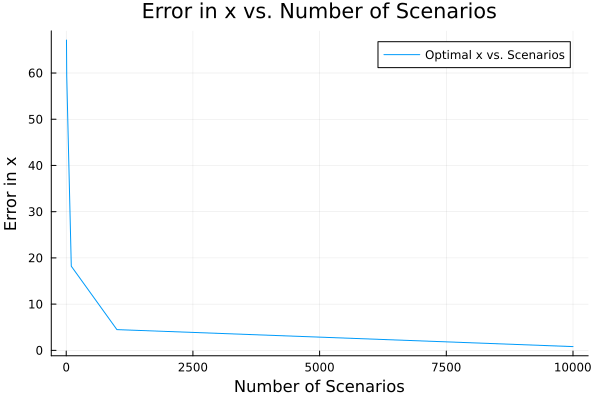

In [66]:
# Plot 1: nb_scenarios against error_x and optimal_objective
plot(nb_scenarios, error_x, xlabel="Number of Scenarios", ylabel="Error in x", label="Optimal x vs. Scenarios", legend=true)
title!("Error in x vs. Number of Scenarios")
# savefig("error_vs_scenarios.png")

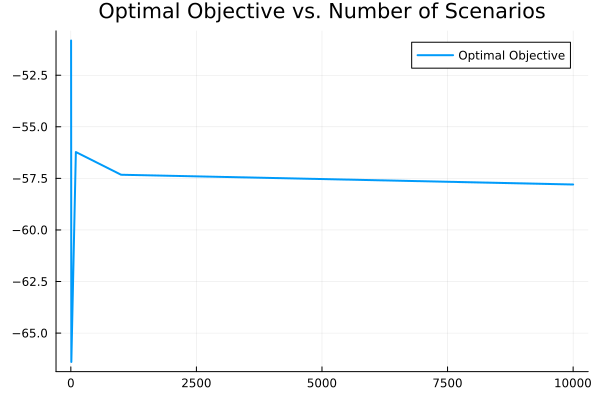

In [65]:

plot(nb_scenarios, optimal_objective, label="Optimal Objective", linewidth=2)
title!("Optimal Objective vs. Number of Scenarios")
# savefig("plots2/optimal_objective.png")

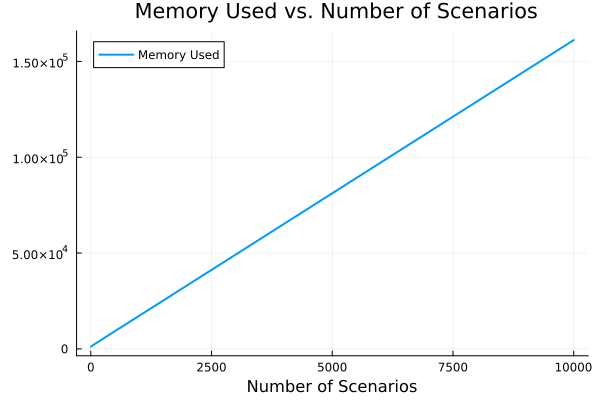

In [64]:

# Plot 2: nb_scenarios against error_x and memory_used
plot(nb_scenarios, memory_used, xlabel="Number of Scenarios",label="Memory Used", linewidth=2)
title!(" Memory Used vs. Number of Scenarios")
# savefig("plots2/memory_used.png")

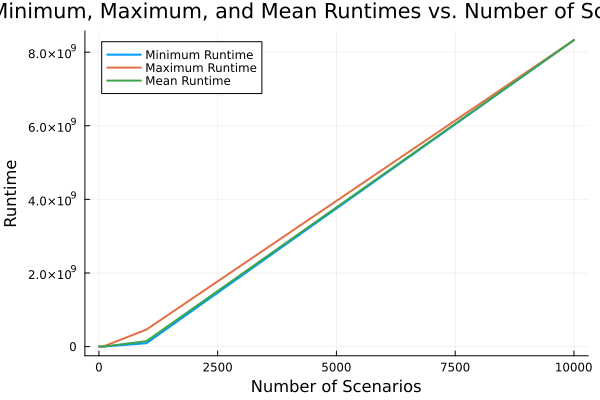

In [63]:
# Plot 3: nb_scenarios against min_runtime, max_runtime, and mean_runtime
plot(nb_scenarios, min_runtime, label="Minimum Runtime", xlabel="Number of Scenarios", ylabel="Runtime",
    legend=true, linewidth=2)
plot!(nb_scenarios, max_runtime, label="Maximum Runtime", linewidth=2)
plot!(nb_scenarios, mean_runtime, label="Mean Runtime", linewidth=2)
title!("Minimum, Maximum, and Mean Runtimes vs. Number of Scenarios")
# savefig("plots2/runtime_statistics.png")

On observe clairement qu'une augmentation faible du nombre d'experiments permet de diminuer largement l'erreur.
Ensuite, malgré une augmentation linéaire du runtime et de la mémoire, la diminution de l'erreur est marginale.